In [ ]:
# ==========================================
# 1. IMPORT LIBRARY
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix





In [3]:
# ==========================================
# 2. LOAD DATASET
# ==========================================
from google.colab import files



# Baca dataset utama
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
previous_app = pd.read_csv("previous_application.csv")
pos_cash = pd.read_csv("POS_CASH_balance.csv")
installments = pd.read_csv("installments_payments.csv")
credit_card = pd.read_csv("credit_card_balance.csv")


In [12]:
# ==========================================
# 3. PROBLEM RESEARCH
# ==========================================
print("Dataset Utama - application_train:")
print(app_train.info())
print(app_train.head())




Dataset Utama - application_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 126 entries, SK_ID_CURR to NAME_CONTRACT_STATUS
dtypes: float64(69), int64(41), object(16)
memory usage: 295.6+ MB
None
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY  \
0               Y             0          202500.0      406597.5      24700.5   
1               N             0          270000.0     1293502.5      35698.5   
2               Y             0           67500.0      135000.0       6750.0   
3               Y      

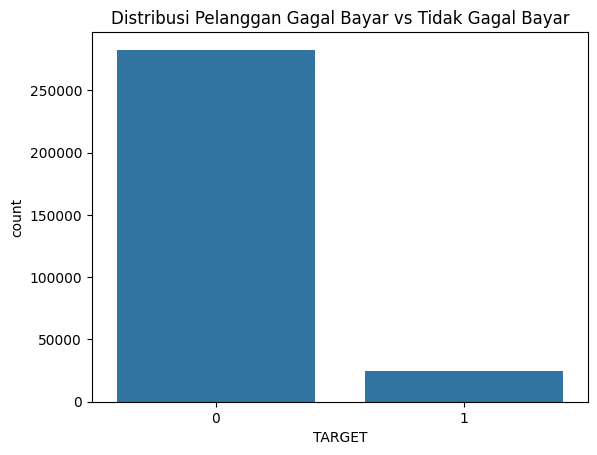

In [13]:
# Cek distribusi target (0 = Tidak Gagal Bayar, 1 = Gagal Bayar)
sns.countplot(x='TARGET', data=app_train)
plt.title("Distribusi Pelanggan Gagal Bayar vs Tidak Gagal Bayar")
plt.show()


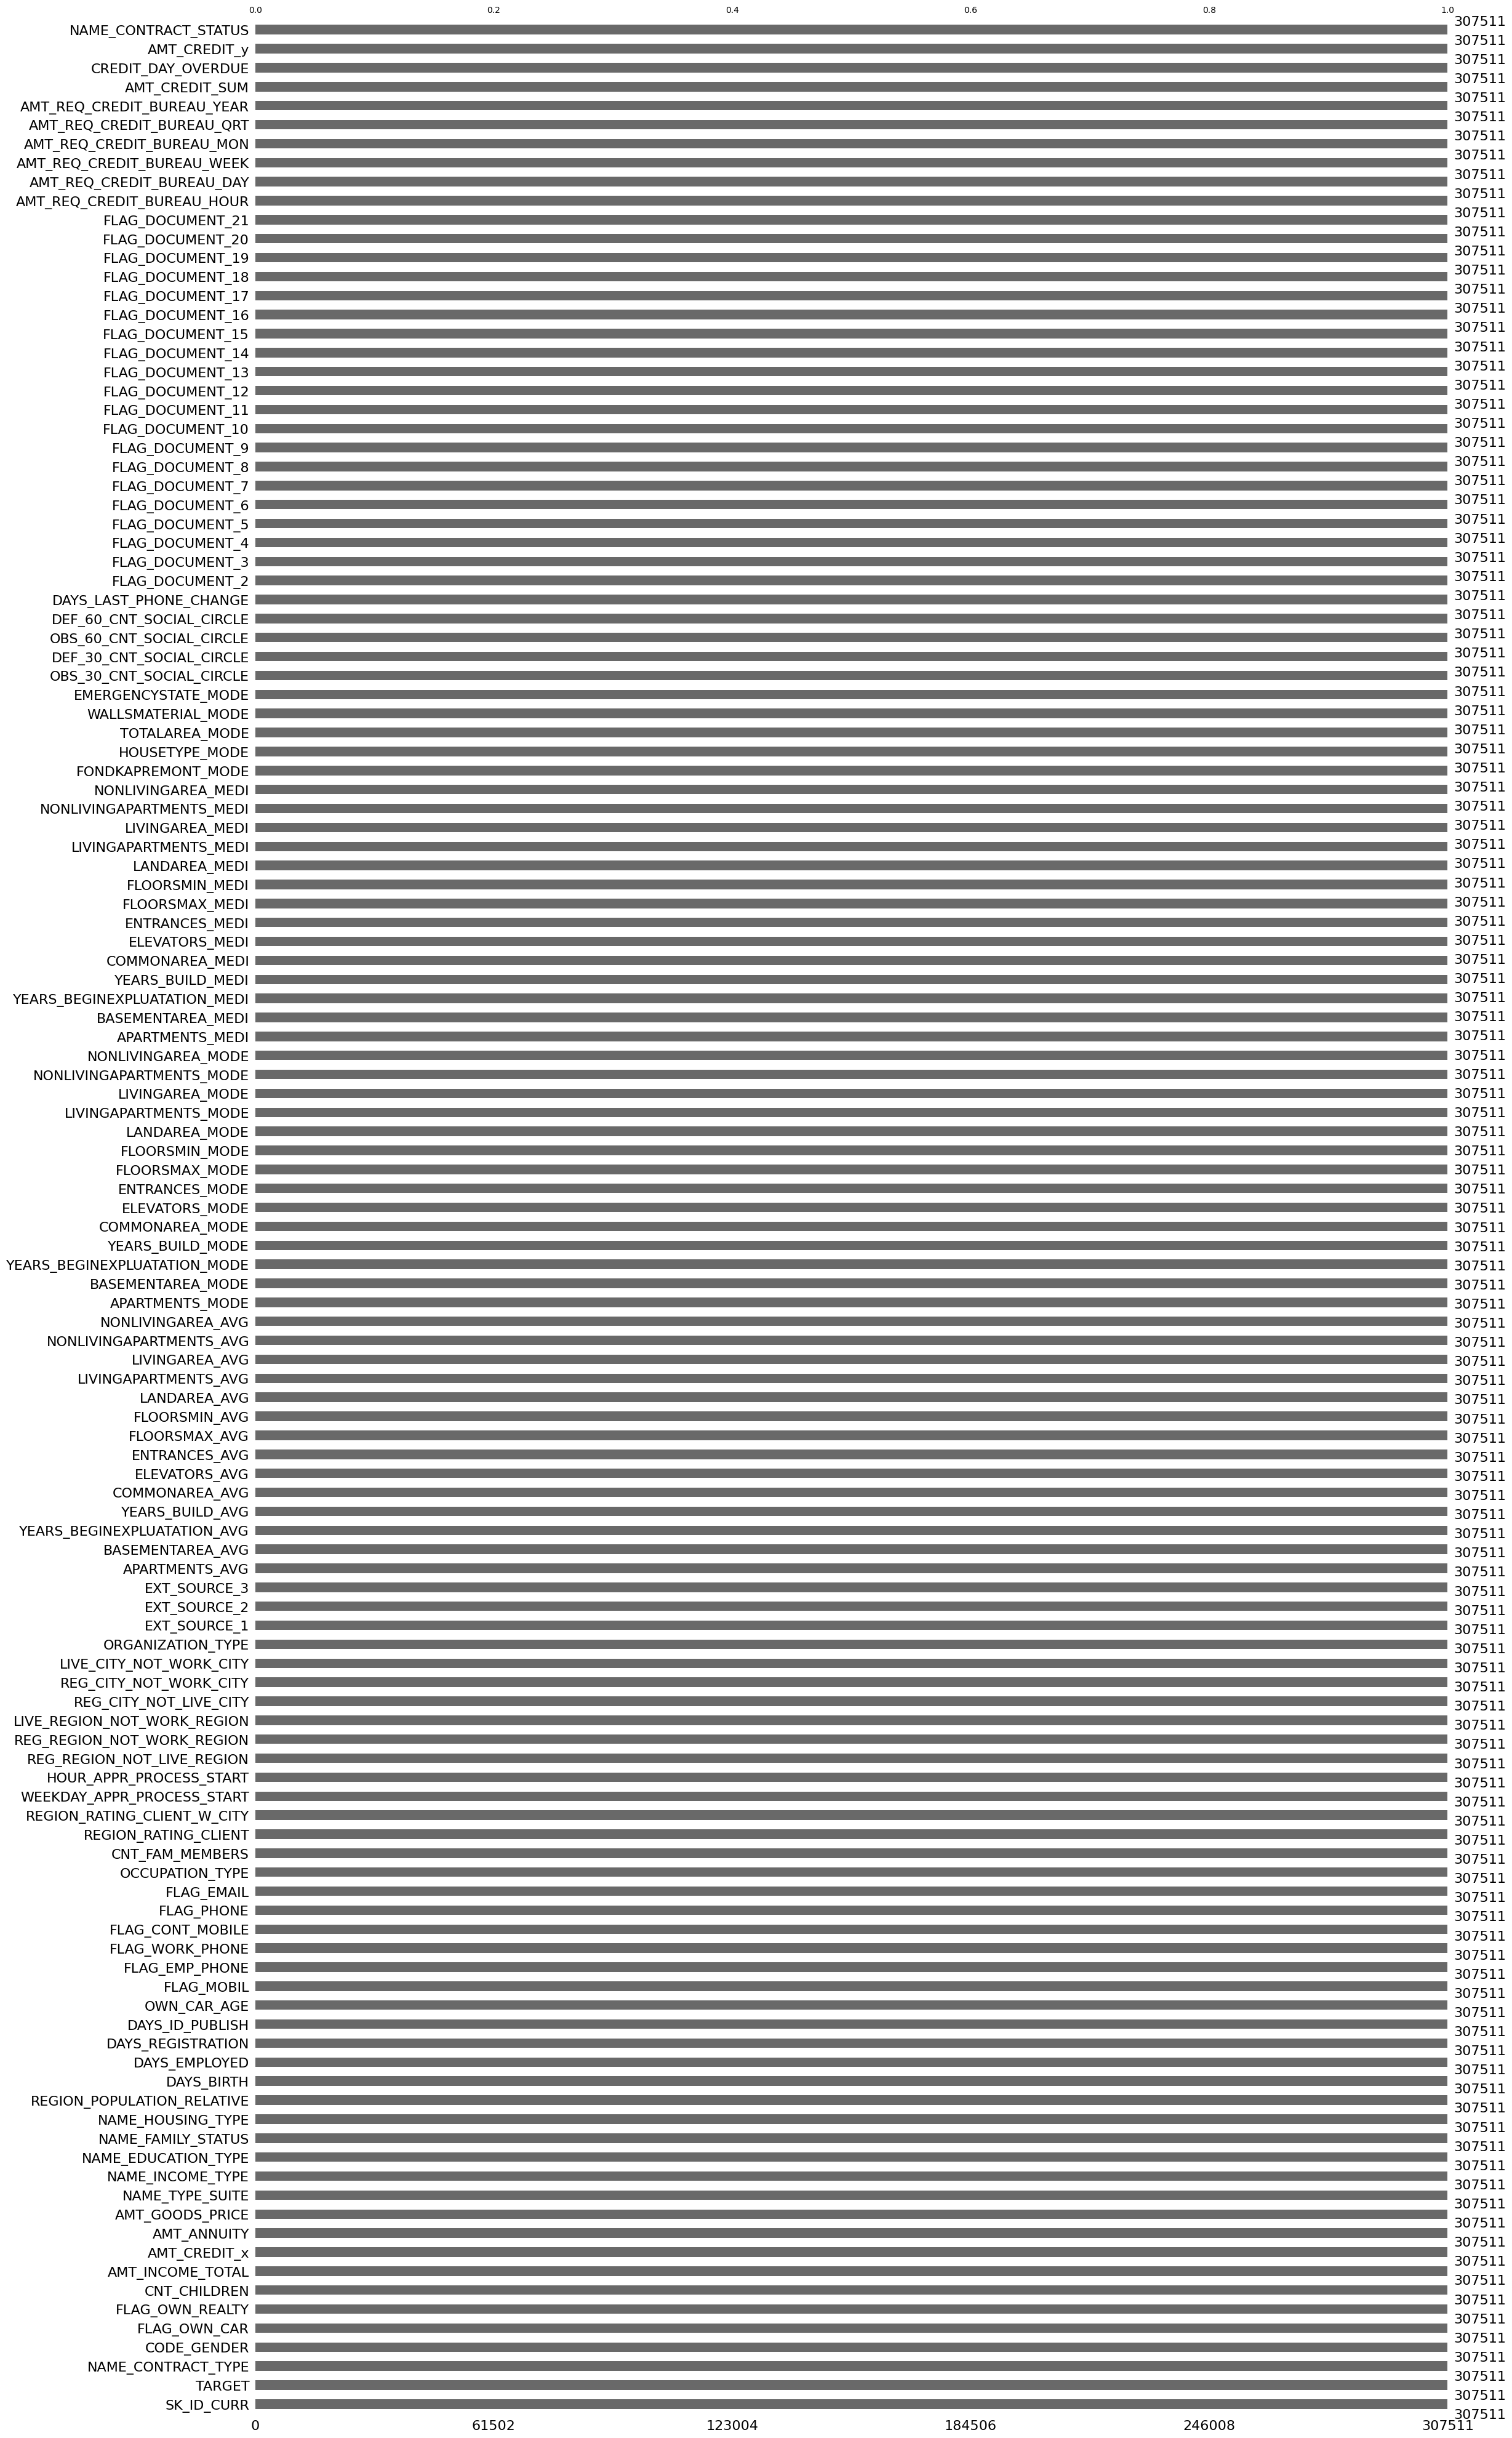

In [14]:
# Cek missing values
msno.bar(app_train)
plt.show()

In [5]:
# ==========================================
# 4. DATA PREPROCESSING
# ==========================================
# Gabungkan informasi dari dataset lain
bureau_agg = bureau.groupby("SK_ID_CURR").agg({"AMT_CREDIT_SUM": "sum", "CREDIT_DAY_OVERDUE": "max"}).reset_index()
app_train = app_train.merge(bureau_agg, on="SK_ID_CURR", how="left")

previous_agg = previous_app.groupby("SK_ID_CURR").agg({"AMT_CREDIT": "sum", "NAME_CONTRACT_STATUS": "nunique"}).reset_index()
app_train = app_train.merge(previous_agg, on="SK_ID_CURR", how="left")

# Isi missing values dengan 0
app_train.fillna(0, inplace=True)

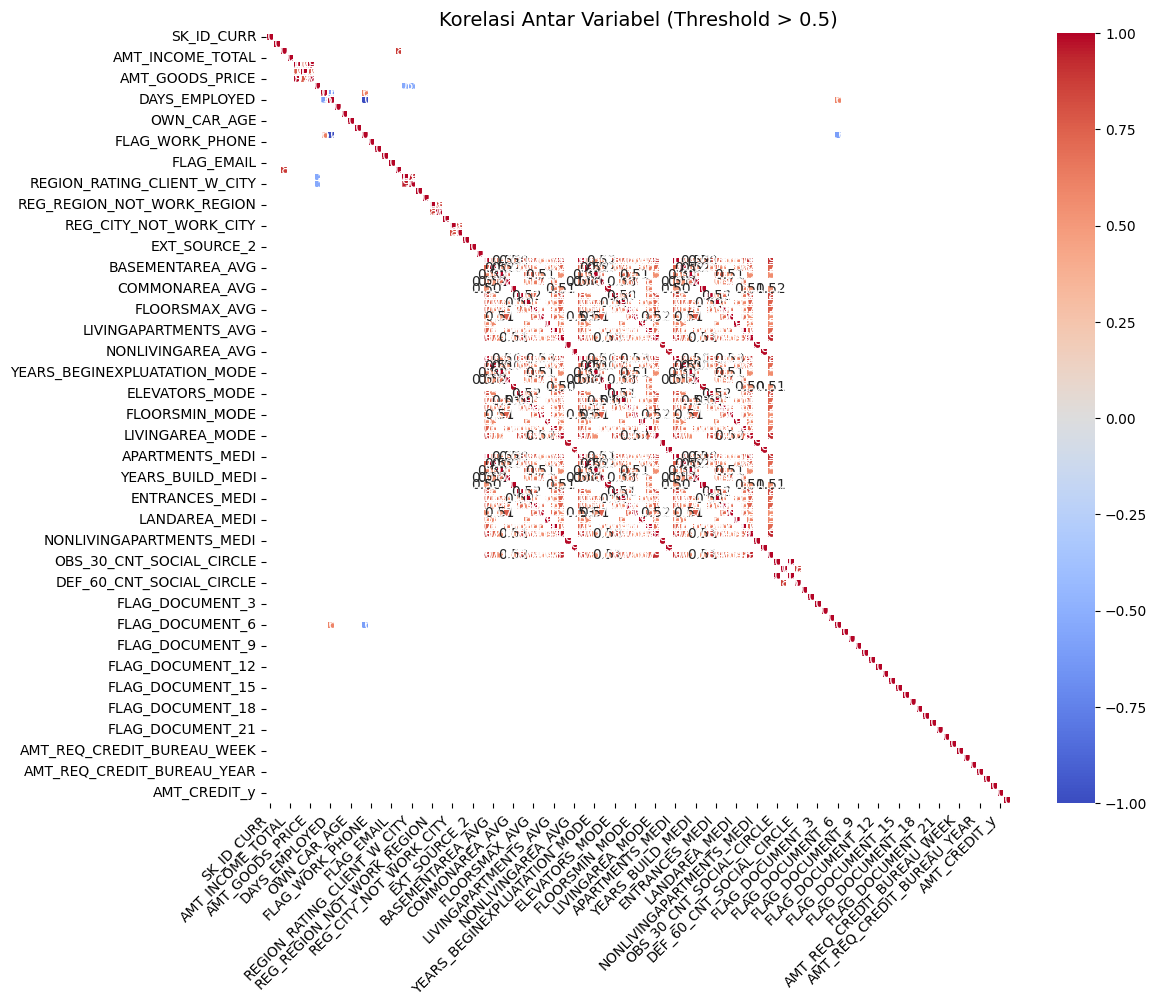

In [16]:
# ==========================================
# 5. DATA VISUALIZATION AND BUSINESS INSIGHT
# ==========================================
# Pastikan kolom AMT_INCOME_TOTAL bertipe numerik
# Menghitung korelasi hanya untuk kolom numerik
corr_matrix = app_train.select_dtypes(include=[np.number]).corr()

# Memilih hanya korelasi yang cukup tinggi (>|0.5|) agar lebih rapi
corr_high = corr_matrix[abs(corr_matrix) > 0.5]

# Set ukuran figure lebih besar
plt.figure(figsize=(12, 10))

# Membuat heatmap dengan warna yang lebih jelas
sns.heatmap(corr_high, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Memutar label sumbu agar tidak bertumpuk
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Korelasi Antar Variabel (Threshold > 0.5)", fontsize=14)

plt.show()


In [10]:
# ==========================================
# 6. MACHINE LEARNING IMPLEMENTATION
# ==========================================
# 1. Pilih fitur dan target
X = app_train.drop(columns=["TARGET", "SK_ID_CURR"])
y = app_train["TARGET"]

# 2. Konversi variabel kategorikal menjadi numerik
X = pd.get_dummies(X)

# 3. Mengatasi nilai yang hilang (NaN) dengan mengganti ke median
X.fillna(X.median(), inplace=True)

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Normalisasi data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 7. Prediksi
y_pred = model.predict(X_test)

# 8. Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9195323805342829

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.50      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503


Confusion Matrix:
 [[56553     1]
 [ 4948     1]]


In [11]:
# ==========================================
# 7. BUSINESS RECOMMENDATION
# ==========================================
recommendations = """
Rekomendasi Bisnis:
1. Perusahaan harus meningkatkan verifikasi penghasilan bagi pelanggan dengan penghasilan < 5 juta karena mereka lebih cenderung gagal bayar.
2. Pelanggan yang memiliki lebih dari 3 kredit aktif lebih berisiko gagal bayar → Buat aturan pembatasan jumlah kredit aktif.
3. Gunakan model prediksi ini sebagai alat bantu dalam pengambilan keputusan pemberian pinjaman untuk mengurangi risiko gagal bayar.
"""

print(recommendations)


Rekomendasi Bisnis:
1. Perusahaan harus meningkatkan verifikasi penghasilan bagi pelanggan dengan penghasilan < 5 juta karena mereka lebih cenderung gagal bayar.
2. Pelanggan yang memiliki lebih dari 3 kredit aktif lebih berisiko gagal bayar → Buat aturan pembatasan jumlah kredit aktif.
3. Gunakan model prediksi ini sebagai alat bantu dalam pengambilan keputusan pemberian pinjaman untuk mengurangi risiko gagal bayar.

